In [2]:
import pandas as pd
import json
from pandas import json_normalize

In [3]:
import datetime as dt

In [4]:
import numpy as np
import shapely.geometry as sg
from matplotlib import cm
from matplotlib.lines import Line2D

In [5]:
!pip install geopandas
import geopandas

In [6]:
import matplotlib.pyplot as plt

In [7]:
with open('/content/drive/MyDrive/CASE_IFOOD/Gmaps/Histórico de localização.json') as data_file:
  data = json.load(data_file)

In [8]:
df = json_normalize(data)
df.head()

,timestampMs,latitudeE7,longitudeE7,accuracy,activity,altitude,verticalAccuracy,velocity,heading
0,1468850826205,-235145853,-463611635,24,"[{'timestampMs': '1468850836455', 'activity': ...",NaN,NaN,NaN,NaN
1,1468850974589,-235101483,-463644180,1500,"[{'timestampMs': '1468850938727', 'activity': ...",NaN,NaN,NaN,NaN
2,1468851089062,-235101483,-463644180,1500,"[{'timestampMs': '1468851083948', 'activity': ...",NaN,NaN,NaN,NaN
3,1468851104231,-235144876,-463610515,28,NaN,NaN,NaN,NaN,NaN
4,1468851129113,-235144876,-463610515,351,"[{'timestampMs': '1468851134225', 'activity': ...",NaN,NaN,NaN,NaN


### Desaninhando as colunas activity e activity.activity e juntando ao df final.

In [9]:
df_start_=pd.json_normalize(json.loads(df.explode('activity').to_json(orient="records")))
df_start_.head()

,timestampMs,latitudeE7,longitudeE7,accuracy,altitude,verticalAccuracy,velocity,heading,activity.timestampMs,activity.activity,activity
0,1468850826205,-235145853,-463611635,24,NaN,NaN,NaN,NaN,1468850836455,"[{'type': 'STILL', 'confidence': 38}, {'type':...",NaN
1,1468850974589,-235101483,-463644180,1500,NaN,NaN,NaN,NaN,1468850938727,"[{'type': 'IN_VEHICLE', 'confidence': 44}, {'t...",NaN
2,1468851089062,-235101483,-463644180,1500,NaN,NaN,NaN,NaN,1468851083948,"[{'type': 'UNKNOWN', 'confidence': 58}, {'type...",NaN
3,1468851089062,-235101483,-463644180,1500,NaN,NaN,NaN,NaN,1468851017537,"[{'type': 'STILL', 'confidence': 48}, {'type':...",NaN
4,1468851104231,-235144876,-463610515,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_act=pd.json_normalize(json.loads(df_start_.explode('activity.activity').to_json(orient="records")))
df_act.head()

,timestampMs,latitudeE7,longitudeE7,accuracy,altitude,verticalAccuracy,velocity,heading,activity.timestampMs,activity,activity.activity.type,activity.activity.confidence,activity.activity
0,1468850826205,-235145853,-463611635,24,NaN,NaN,NaN,NaN,1468850836455,None,STILL,38.0,NaN
1,1468850826205,-235145853,-463611635,24,NaN,NaN,NaN,NaN,1468850836455,None,UNKNOWN,38.0,NaN
2,1468850826205,-235145853,-463611635,24,NaN,NaN,NaN,NaN,1468850836455,None,IN_VEHICLE,23.0,NaN
3,1468850974589,-235101483,-463644180,1500,NaN,NaN,NaN,NaN,1468850938727,None,IN_VEHICLE,44.0,NaN
4,1468850974589,-235101483,-463644180,1500,NaN,NaN,NaN,NaN,1468850938727,None,STILL,27.0,NaN


In [11]:
df_final = pd.concat([df, df_act, df_start_],axis=1)
df_final.head()

,timestampMs,latitudeE7,longitudeE7,accuracy,activity,altitude,verticalAccuracy,velocity,heading,timestampMs,latitudeE7,longitudeE7,accuracy,altitude,verticalAccuracy,velocity,heading,activity.timestampMs,activity,activity.activity.type,activity.activity.confidence,activity.activity,timestampMs,latitudeE7,longitudeE7,accuracy,altitude,verticalAccuracy,velocity,heading,activity.timestampMs,activity.activity,activity
0,1468850826205,-235145853.0,-463611635.0,24.0,"[{'timestampMs': '1468850836455', 'activity': ...",NaN,NaN,NaN,NaN,1468850826205,-235145853,-463611635,24,NaN,NaN,NaN,NaN,1468850836455,None,STILL,38.0,NaN,1468850826205,-235145853.0,-463611635.0,24.0,NaN,NaN,NaN,NaN,1468850836455,"[{'type': 'STILL', 'confidence': 38}, {'type':...",NaN
1,1468850974589,-235101483.0,-463644180.0,1500.0,"[{'timestampMs': '1468850938727', 'activity': ...",NaN,NaN,NaN,NaN,1468850826205,-235145853,-463611635,24,NaN,NaN,NaN,NaN,1468850836455,None,UNKNOWN,38.0,NaN,1468850974589,-235101483.0,-463644180.0,1500.0,NaN,NaN,NaN,NaN,1468850938727,"[{'type': 'IN_VEHICLE', 'confidence': 44}, {'t...",NaN
2,1468851089062,-235101483.0,-463644180.0,1500.0,"[{'timestampMs': '1468851083948', 'activity': ...",NaN,NaN,NaN,NaN,1468850826205,-235145853,-463611635,24,NaN,NaN,NaN,NaN,1468850836455,None,IN_VEHICLE,23.0,NaN,1468851089062,-235101483.0,-463644180.0,1500.0,NaN,NaN,NaN,NaN,1468851083948,"[{'type': 'UNKNOWN', 'confidence': 58}, {'type...",NaN
3,1468851104231,-235144876.0,-463610515.0,28.0,NaN,NaN,NaN,NaN,NaN,1468850974589,-235101483,-463644180,1500,NaN,NaN,NaN,NaN,1468850938727,None,IN_VEHICLE,44.0,NaN,1468851089062,-235101483.0,-463644180.0,1500.0,NaN,NaN,NaN,NaN,1468851017537,"[{'type': 'STILL', 'confidence': 48}, {'type':...",NaN
4,1468851129113,-235144876.0,-463610515.0,351.0,"[{'timestampMs': '1468851134225', 'activity': ...",NaN,NaN,NaN,NaN,1468850974589,-235101483,-463644180,1500,NaN,NaN,NaN,NaN,1468850938727,None,STILL,27.0,NaN,1468851104231,-235144876.0,-463610515.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_total = df_final.T.groupby(level=0).first().T
df_total.head()

,accuracy,activity,activity.activity,activity.activity.confidence,activity.activity.type,activity.timestampMs,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy
0,24,"[{'timestampMs': '1468850836455', 'activity': ...","[{'type': 'STILL', 'confidence': 38}, {'type':...",38,STILL,1468850836455,None,None,-2.35146e+08,-4.63612e+08,1468850826205,None,None
1,1500,"[{'timestampMs': '1468850938727', 'activity': ...","[{'type': 'IN_VEHICLE', 'confidence': 44}, {'t...",38,UNKNOWN,1468850836455,None,None,-2.35101e+08,-4.63644e+08,1468850974589,None,None
2,1500,"[{'timestampMs': '1468851083948', 'activity': ...","[{'type': 'UNKNOWN', 'confidence': 58}, {'type...",23,IN_VEHICLE,1468850836455,None,None,-2.35101e+08,-4.63644e+08,1468851089062,None,None
3,28,None,"[{'type': 'STILL', 'confidence': 48}, {'type':...",44,IN_VEHICLE,1468850938727,None,None,-2.35145e+08,-4.63611e+08,1468851104231,None,None
4,351,"[{'timestampMs': '1468851134225', 'activity': ...",None,27,STILL,1468850938727,None,None,-2.35145e+08,-4.63611e+08,1468851129113,None,None


In [13]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2370411 entries, 0 to 2370410
Data columns (total 13 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   accuracy                      object
 1   activity                      object
 2   activity.activity             object
 3   activity.activity.confidence  object
 4   activity.activity.type        object
 5   activity.timestampMs          object
 6   altitude                      object
 7   heading                       object
 8   latitudeE7                    object
 9   longitudeE7                   object
 10  timestampMs                   object
 11  velocity                      object
 12  verticalAccuracy              object
dtypes: object(13)
memory usage: 253.2+ MB


### Transformando lat e long.

In [14]:
df_total[['latitudeE7', 'longitudeE7']] = df_total[['latitudeE7', 'longitudeE7']].div(10000000)
df_total.head(3)

,accuracy,activity,activity.activity,activity.activity.confidence,activity.activity.type,activity.timestampMs,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy
0,24,"[{'timestampMs': '1468850836455', 'activity': ...","[{'type': 'STILL', 'confidence': 38}, {'type':...",38,STILL,1468850836455,None,None,-23.5146,-46.3612,1468850826205,None,None
1,1500,"[{'timestampMs': '1468850938727', 'activity': ...","[{'type': 'IN_VEHICLE', 'confidence': 44}, {'t...",38,UNKNOWN,1468850836455,None,None,-23.5101,-46.3644,1468850974589,None,None
2,1500,"[{'timestampMs': '1468851083948', 'activity': ...","[{'type': 'UNKNOWN', 'confidence': 58}, {'type...",23,IN_VEHICLE,1468850836455,None,None,-23.5101,-46.3644,1468851089062,None,None


### Transformado lat e long em geometry com o geopandas.

In [15]:
gdf = geopandas.GeoDataFrame(
    df_total, geometry=geopandas.points_from_xy(df_total.longitudeE7, df_total.latitudeE7))

In [16]:
print(gdf.head())

  accuracy  ...                     geometry
0       24  ...  POINT (-46.36116 -23.51459)
1     1500  ...  POINT (-46.36442 -23.51015)
2     1500  ...  POINT (-46.36442 -23.51015)
3       28  ...  POINT (-46.36105 -23.51449)
4      351  ...  POINT (-46.36105 -23.51449)

[5 rows x 14 columns]


### Transformação de timestamp para data, hora, minuto.




In [17]:
df_total['timestamp'] = pd.to_datetime(df_total['timestampMs'], unit='ms')
df_total.head(3)

,accuracy,activity,activity.activity,activity.activity.confidence,activity.activity.type,activity.timestampMs,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy,geometry,timestamp
0,24,"[{'timestampMs': '1468850836455', 'activity': ...","[{'type': 'STILL', 'confidence': 38}, {'type':...",38,STILL,1468850836455,None,None,-23.5146,-46.3612,1468850826205,None,None,POINT (-46.36116 -23.51459),2016-07-18 14:07:06.205
1,1500,"[{'timestampMs': '1468850938727', 'activity': ...","[{'type': 'IN_VEHICLE', 'confidence': 44}, {'t...",38,UNKNOWN,1468850836455,None,None,-23.5101,-46.3644,1468850974589,None,None,POINT (-46.36442 -23.51015),2016-07-18 14:09:34.589
2,1500,"[{'timestampMs': '1468851083948', 'activity': ...","[{'type': 'UNKNOWN', 'confidence': 58}, {'type...",23,IN_VEHICLE,1468850836455,None,None,-23.5101,-46.3644,1468851089062,None,None,POINT (-46.36442 -23.51015),2016-07-18 14:11:29.062


In [18]:
df_total['timestamp'] = pd.to_datetime(df_total['timestamp'],utc=True)
df_total = df_total.set_index('timestamp')
df_total.index = df_total.index.tz_convert('America/Sao_Paulo')
df_total = df_total.reset_index()

In [19]:
df_total['Ano']= df_total['timestamp'].dt.year
df_total['Mês'] =df_total['timestamp'].dt.month
df_total['Dia'] = df_total['timestamp'].dt.day
df_total['Hora'] = df_total['timestamp'].dt.hour
df_total['DiaSemana'] = df_total['timestamp'].dt.day_name()

In [20]:
mes = {	
    1:'Janeiro',
		2:'Fevereiro',
		3:'Março',
		4:'Abril',
		5:'Maio',
		6:'Junho',
		7:'Julho',
		8:'Agosto',
		9:'Setembro',
		10:'Outubro',
		11:'Novembro',
		12:'Dezembro'		
}

df_total["Mês"].replace(mes, inplace=True)

In [21]:
DiaSemana = {	
    'Sunday':'Domingo',
		'Monday':'Segunda',
		'Tuesday':'Terça',
		'Wednesday':'Quarta',
		'Thursday':'Quinta',
		'Friday':'Sexta',
		'Saturday':'Sabado'		
}

df_total["DiaSemana"].replace(DiaSemana, inplace=True)

## Análise Exploratória

### Visulização dos pontos visitados pelo usuário.

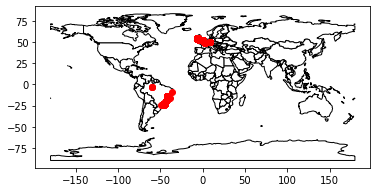

In [22]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', edgecolor='black')

gdf.plot(ax=ax, color='red')

plt.show()

### Tipo de atividade mais comum.

In [23]:
df_total = df_total.rename(columns={'activity.activity.type': 'Atividade'})

In [24]:
df_total.head()

,timestamp,accuracy,activity,activity.activity,activity.activity.confidence,Atividade,activity.timestampMs,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy,geometry,Ano,Mês,Dia,Hora,DiaSemana
0,2016-07-18 11:07:06.205000-03:00,24,"[{'timestampMs': '1468850836455', 'activity': ...","[{'type': 'STILL', 'confidence': 38}, {'type':...",38,STILL,1468850836455,None,None,-23.5146,-46.3612,1468850826205,None,None,POINT (-46.36116 -23.51459),2016,Julho,18,11,Segunda
1,2016-07-18 11:09:34.589000-03:00,1500,"[{'timestampMs': '1468850938727', 'activity': ...","[{'type': 'IN_VEHICLE', 'confidence': 44}, {'t...",38,UNKNOWN,1468850836455,None,None,-23.5101,-46.3644,1468850974589,None,None,POINT (-46.36442 -23.51015),2016,Julho,18,11,Segunda
2,2016-07-18 11:11:29.062000-03:00,1500,"[{'timestampMs': '1468851083948', 'activity': ...","[{'type': 'UNKNOWN', 'confidence': 58}, {'type...",23,IN_VEHICLE,1468850836455,None,None,-23.5101,-46.3644,1468851089062,None,None,POINT (-46.36442 -23.51015),2016,Julho,18,11,Segunda
3,2016-07-18 11:11:44.231000-03:00,28,None,"[{'type': 'STILL', 'confidence': 48}, {'type':...",44,IN_VEHICLE,1468850938727,None,None,-23.5145,-46.3611,1468851104231,None,None,POINT (-46.36105 -23.51449),2016,Julho,18,11,Segunda
4,2016-07-18 11:12:09.113000-03:00,351,"[{'timestampMs': '1468851134225', 'activity': ...",None,27,STILL,1468850938727,None,None,-23.5145,-46.3611,1468851129113,None,None,POINT (-46.36105 -23.51449),2016,Julho,18,11,Segunda


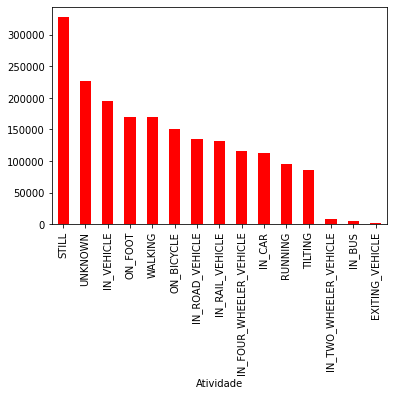

In [25]:
df_total.groupby(by=df_total.Atividade).agg('count').geometry.sort_values(ascending=False).plot.bar(color='r');

### Dias da semana com maior número de atividades.

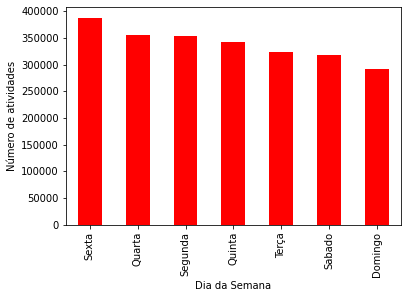

In [26]:
df_total['DiaSemana'].value_counts().plot.bar(color='r', xlabel='Dia da Semana', ylabel = 'Número de atividades');

### Hora do dia com mais atividades.

In [27]:
df_total['Hora'] = pd.Categorical(df_total['Hora'], categories=
    [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
    ordered=True)

ativ_hora = df_total['Hora'].value_counts()
ativ_hora = ativ_hora.sort_index()

ativ_hora

0      94796
1      54794
2      34687
3      26314
4      24748
5      27930
6      63967
7      77688
8      91408
9      98027
10    115832
11    122434
12    143647
13    143669
14    122570
15    103283
16    118837
17    126826
18    130927
19    129212
20    122141
21    115394
22    142119
23    139161
Name: Hora, dtype: int64

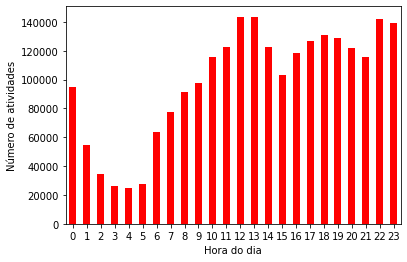

In [28]:
ativ_hora.plot(kind='bar', color = 'r', rot=0, xlabel='Hora do dia', ylabel = 'Número de atividades');

### Mês com mais atividades

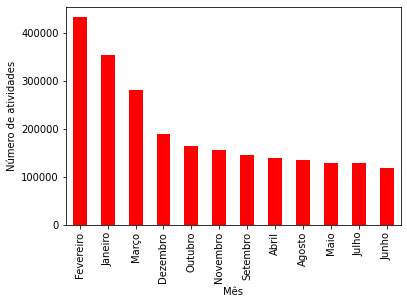

In [29]:
df_total['Mês'].value_counts().plot.bar(color='r', xlabel='Mês', ylabel = 'Número de atividades');

### Anos com mais atividades

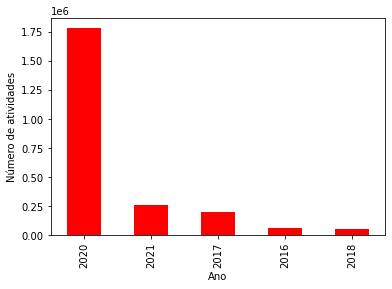

In [30]:
df_total['Ano'].value_counts().plot.bar(color='r', xlabel='Ano', ylabel = 'Número de atividades');

In [31]:
df_total.drop(['activity', 'activity.activity'], axis =1, inplace=True)

### Obtendo distâncias a partir da lat e long.


In [32]:
from geopy import Point
from geopy.distance import distance

In [33]:
df_total['point'] = df_total.apply(lambda row: Point(latitude=row['latitudeE7'], longitude=row['longitudeE7']), axis=1)

In [34]:
df_total['point_next'] = df_total['point'].shift(1)
df_total.loc[df_total['point_next'].isna(), 'point_next'] = None

In [35]:
df_total['distance_km'] = df_total.apply(lambda row: distance(row['point'], row['point_next']).km if row['point_next'] is not None else float('nan'), axis=1)
df_total = df_total.drop('point_next', axis=1)

In [36]:
df_total.head()

,timestamp,accuracy,activity.activity.confidence,Atividade,activity.timestampMs,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy,geometry,Ano,Mês,Dia,Hora,DiaSemana,point,distance_km
0,2016-07-18 11:07:06.205000-03:00,24,38,STILL,1468850836455,None,None,-23.5146,-46.3612,1468850826205,None,None,POINT (-46.36116 -23.51459),2016,Julho,18,11,Segunda,"23 30m 52.5071s S, 46 21m 40.1886s W",NaN
1,2016-07-18 11:09:34.589000-03:00,1500,38,UNKNOWN,1468850836455,None,None,-23.5101,-46.3644,1468850974589,None,None,POINT (-46.36442 -23.51015),2016,Julho,18,11,Segunda,"23 30m 36.5339s S, 46 21m 51.9048s W",0.593261
2,2016-07-18 11:11:29.062000-03:00,1500,23,IN_VEHICLE,1468850836455,None,None,-23.5101,-46.3644,1468851089062,None,None,POINT (-46.36442 -23.51015),2016,Julho,18,11,Segunda,"23 30m 36.5339s S, 46 21m 51.9048s W",0.000000
3,2016-07-18 11:11:44.231000-03:00,28,44,IN_VEHICLE,1468850938727,None,None,-23.5145,-46.3611,1468851104231,None,None,POINT (-46.36105 -23.51449),2016,Julho,18,11,Segunda,"23 30m 52.1554s S, 46 21m 39.7854s W",0.590911
4,2016-07-18 11:12:09.113000-03:00,351,27,STILL,1468850938727,None,None,-23.5145,-46.3611,1468851129113,None,None,POINT (-46.36105 -23.51449),2016,Julho,18,11,Segunda,"23 30m 52.1554s S, 46 21m 39.7854s W",0.000000


### Analisando as distâncias percorridas.

In [37]:
dist_ano = df_total.groupby('Ano')['distance_km'].sum()
dist_ano

Ano
2016    1.142670e+04
2017    6.094308e+04
2018    1.165944e+04
2020    1.007015e+07
2021    5.099679e+04
Name: distance_km, dtype: float64

In [38]:
dist_mes = df_total.groupby('Mês')['distance_km'].sum()
dist_mes

Mês
Abril        3.891005e+04
Agosto       3.535967e+04
Dezembro     4.598001e+04
Fevereiro    4.804878e+05
Janeiro      6.274032e+04
Julho        8.466899e+06
Junho        2.998334e+04
Maio         2.801792e+04
Março        4.078382e+05
Novembro     4.768009e+05
Outubro      6.891707e+04
Setembro     6.324092e+04
Name: distance_km, dtype: float64

In [40]:
dist_dia = df_total.groupby('DiaSemana')['distance_km'].sum()
dist_dia

DiaSemana
Domingo    1.461057e+06
Quarta     1.559875e+06
Quinta     1.627490e+06
Sabado     1.512285e+06
Segunda    1.520886e+06
Sexta      1.609413e+06
Terça      9.141695e+05
Name: distance_km, dtype: float64

In [41]:
df_total.to_csv('/content/drive/MyDrive/CASE_IFOOD/Dados_Finais/gmaps_case_ifoodv2.csv')